In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [2]:
file_paths = {'in':'../../data/cleaned/activities/4439566437.csv'
             }

df = pd.read_csv(file_paths['in'])

# guarantee the timestamps are datetime objects
df['time'] = pd.to_datetime(df['time'])

In [3]:
if 'index' in df.columns:
    df.drop(['index'], axis=1, inplace=True)

In [4]:
df.head()

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,heading,speed,is_cruising,grade,elapsed_ascent,elapsed_descent,elapsed_elevation,training_window_id,filt_speed,filt_grade
0,2020-12-06 18:36:38+00:00,4.439566e+09,0.0,884.8857,40.067950,-83.127786,1.0,1.0,1.0,NaN,NaN,6.259034,False,0.0,0.0,0.0,0.0,6,3.172414,0.0
1,2020-12-06 18:36:39+00:00,4.439566e+09,0.0,884.8857,40.067975,-83.127779,2.0,1.0,2.0,0.001739,72.979474,6.259034,False,0.0,0.0,0.0,0.0,6,4.504257,0.0
2,2020-12-06 18:36:40+00:00,4.439566e+09,0.0,884.8857,40.067999,-83.127771,3.0,1.0,3.0,0.001739,72.979474,6.259034,False,0.0,0.0,0.0,0.0,6,5.225672,0.0
3,2020-12-06 18:36:41+00:00,4.439566e+09,0.0,884.8857,40.068021,-83.127801,4.0,1.0,4.0,0.002197,143.746162,7.909226,False,0.0,0.0,0.0,0.0,6,5.034892,0.0
4,2020-12-06 18:36:42+00:00,4.439566e+09,0.0,884.8857,40.068023,-83.127808,5.0,1.0,5.0,0.000395,164.054604,1.422308,False,0.0,0.0,0.0,0.0,6,4.021185,0.0


### Grab Segment 22 as the longest representative segment

In [5]:
df22 = df.loc[df['segment_id']==22,:].reset_index()

### Acquire the Bike Weight from Activity Log

In [6]:
ride_id = 4439566437

In [7]:
df_log = pd.read_csv('../../data/cleaned/activity_log.csv')

In [9]:
df_log = df_log.set_index('ride_id')
bike_weight = df_log.loc[ride_id, 'bike_weight']
print(f'bike weighs {bike_weight} kg')

bike weighs 15.8757 kg


# 1. Define Power Calculation Parameters

In [13]:
params = {'total_mass': bike_weight + 86.1826, # kg
          'area': 0.4635862, # m^2
          'mu_rr': 0.005, # coefficient of rolling friction
          'c_drag': 0.95, # coefficient of drag
          'rho_air': 1.2, # kg/m^3 air density
          'eta_dt': 0.96, # efficiency of drive train
          'gravity': 9.8 # m/s^2
         }

# 2. Convert the Imperial Columns to Metric
Also convert the grade into an angle

In [31]:
df22['filt_grade_radians'] = np.arctan(df22['filt_grade']/100)

In [32]:
mph2MpS = 0.44704 # 1 MPH = 0.44704 m/s
df22['filt_speed_MpS'] = mph2MpS * df22['filt_speed']

# 3. Compute the Forces Resisting Motion

In [33]:
params['total_mass']*params['gravity']

1000.17134

In [34]:
df22['F_grav'] = params['total_mass']*params['gravity'] * np.sin(df22['filt_grade_radians'])

In [35]:
df22['F_fric'] = params['mu_rr']*params['total_mass']*params['gravity'] * np.cos(df22['filt_grade_radians'])

In [36]:
def get_wind_velocity_component(df, df_log):
    # TODO: add in weather data and a cosine between wind bearing and bike heading to project the contribution of wind
    # onto the direction of motion
    df = df.copy()
    df['wind_velocity_component'] = 0 # constant zero for now
    return df
    

In [37]:
df22 = get_wind_velocity_component(df22, df_log)

In [38]:
full_coefficient = 0.5 * params['rho_air'] * params['area'] * params['c_drag']
df22['F_drag'] = (full_coefficient) * np.power(df22['filt_speed_MpS']+df22['wind_velocity_component'], 2) # k*(v+wind)^2

In [56]:
df22['F_sum'] = df22['F_drag'] + df22['F_grav'] + df22['F_fric']

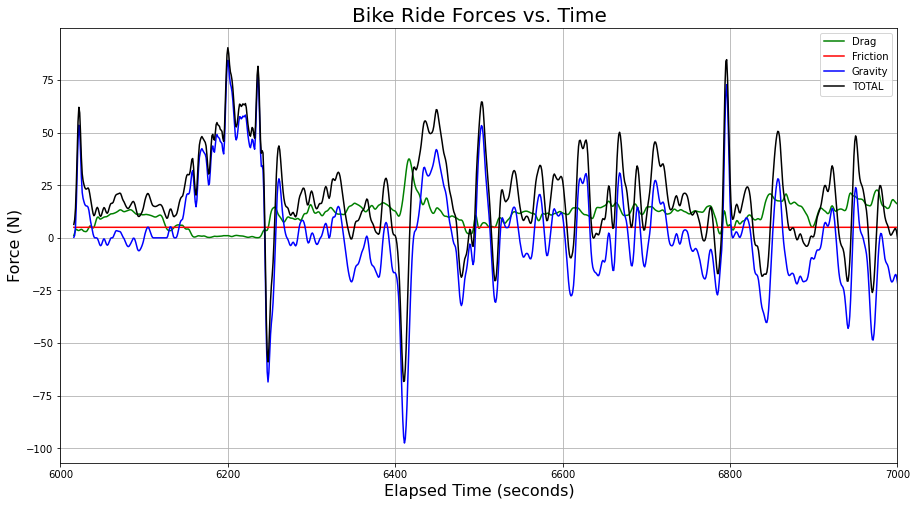

In [59]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,8))

_ = sns.lineplot(x='elapsed_time', y='F_drag', data=df22, color='g', label='Drag')
_ = sns.lineplot(x='elapsed_time', y='F_fric', data=df22, color='r', label='Friction')
_ = sns.lineplot(x='elapsed_time', y='F_grav', data=df22, color='b', label='Gravity')
_ = sns.lineplot(x='elapsed_time', y='F_sum', data=df22, color='k', label='TOTAL')

_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Force (N)', fontsize=16)
_ = plt.title('Bike Ride Forces vs. Time', fontsize=20)
_ = plt.grid()
_ = plt.xlim([6000, 7000])

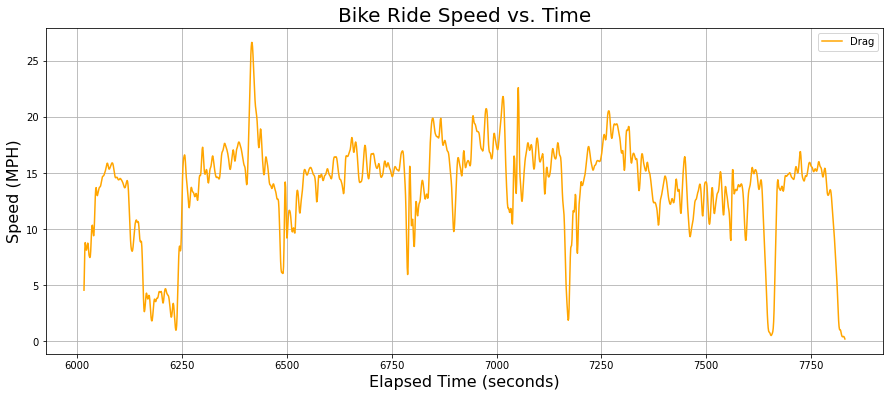

In [63]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,6))

_ = sns.lineplot(x='elapsed_time', y='filt_speed', data=df22, color='orange', label='Drag')

_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()

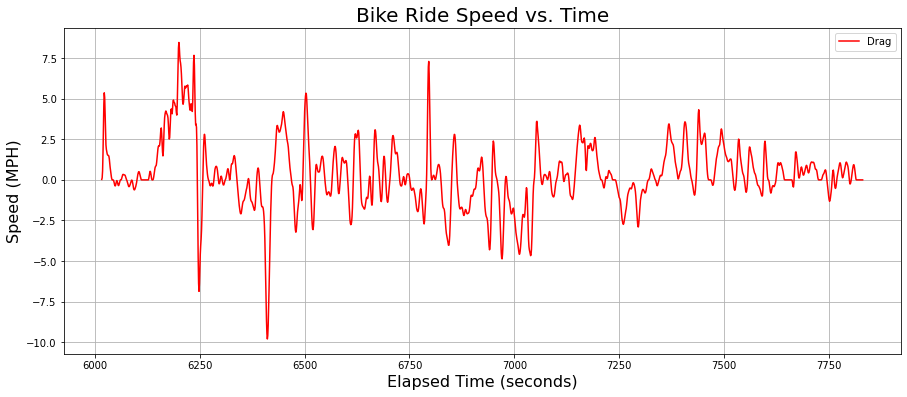

In [64]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,6))

_ = sns.lineplot(x='elapsed_time', y='filt_grade', data=df22, color='r', label='Drag')

_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()